In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (9,9)

HTML [Demo app](demo.html)

# Lattice invariants and quadratic forms

Let $x\rightarrow Mx$ transform is a lattice invariant (i.e. $M$ is integer, and $\det(M)=1$).

Then how to find equation $x'Ax = 1$ that is unchagned by it? Matrix $A$ must satisfy:

$$ M'AM=A $$

This is Lyapunov equation

Using Maxima, the following solution was obtained:
$$ A = \left(\begin{matrix}
  2 c & d-a\\
  d-a & -2 b
\end{matrix}\right) $$

where

$$ M=\left(\begin{matrix}a & b \\ c & d\end{matrix}\right) $$.

In [2]:
def tfm2qform(m):
    """Convert identity transofrm to quadratic form matrix, simpler implementation"""
    (a,b),(c,d) = m
    return np.array([[2*c,d-a],[d-a, -2*b]])

In [3]:
tfm2qform([[2,1],[1,1]])

array([[ 2, -1],
       [-1, -2]])

Maxima code:
```m:matrix([a,b],[c,d]);
aa:matrix([x,y],[y,z]);
mam : ratsimp(transpose(m).aa.m);
zz: mam - aa*determinant(m);
ss:solve([zz[1,1],zz[1,2],zz[2,2]],[x,y,z]);
subst(%r2=1,subst(ss[1], aa)*2*c);
```

In [4]:
def lattice(v,n=5, show=True):
    x = np.linspace(-n,n,n*2+1)
    xx,yy = np.meshgrid(x,x)
    ppp = np.stack((xx.ravel(),yy.ravel()))
    vvv = np.dot(v, ppp)
    plt.plot(vvv[0,:],vvv[1,:],"bo")
    show and plt.show()


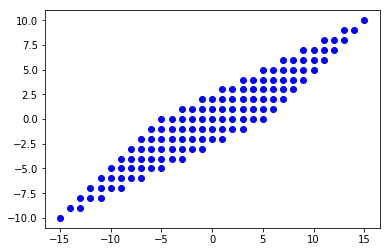

In [5]:
lattice([[2,1],[1,1]])

# Double neighbor
The most important question for the CA simulator: given 2 cells, find their common neighbors.

Let the translation vector between cells is $p$. Then the answer is given by integer solution of the intersection of 2 equal conics, one is central, second is translated by $p$:
$$\begin{cases} x^TAx = c \\
                (x-p)^TA(x-p) = c
  \end{cases}$$
 
Expand 2nd

$$ x^TAx -2p^TAx+p^TAp = c  $$
$$ 2p^TAx=p^TAp $$

therefore 
$$x = \frac12 p + tq$$

where $p^TAq=0$. The latter means that $q \perp Ap$, and also $Aq \perp p$



substituting into 1st:

$$ (\frac12 p+tq)'A(1/2p+tq) = c$$
$$ \frac14 p'Ap + t p'Aq + t^2 q'Aq = c$$

Since $p'Aq=0$, this gives
$$ \frac14 p'Ap + t^2 q'Aq = c$$

thus,
$$t = \sqrt{ \frac{c-\frac14p'Ap}{q'Aq} }$$

therefore
$$ x =  \frac12 p \pm q\sqrt{ \frac{c-\frac14p'Ap}{q'Aq} }$$

In 2d case, $q = RAp$ or $A^{-1}Rp$, where 
$$R=\left( \begin{matrix} 0 & -1 \\ 1 & 0  \end{matrix} \right)$$

THus $q'Aq = p'AR'ARAp$ or $q'Aq = p'R'A^{-1}Rp$


Let's check whether $RA$ is reallly proportional to $A^{-1}R$...

In [6]:
a=np.array([[2,1],[1,3]])
r=np.array([[0,-1],[1,0]])

print(r.dot(a))
print(np.linalg.inv(a).dot(r) * np.linalg.det(a))

[[-1 -3]
 [ 2  1]]
[[-1. -3.]
 [ 2.  1.]]


Yes, this seems to be right. Numeric check confirms. that

$$RA = \det(A) A^{-1}R = A^+R$$

From now on, use $q=RAp = \det(A)A^{-1}Rp$

Thus, $ p'AR'ARAp = \det(A) p'AR'A A^{-1}Rp = \det(A) p'Ap$

Therefore, 
$$q'Aq = \det(A)p'Ap$$

Thus,
$$ x =  \frac12 p \pm \frac12 q\sqrt{ \frac{4c-p'Ap}{\det(A)p'Ap} }$$
or, substituting $q$, finally obtaining

$$ x =  \frac12 p \pm \frac12 RAp\sqrt{ \frac{4c-p'Ap}{\det(A)p'Ap} }$$

In [10]:
#test code
import math
def intersection(a, p, c):
    p=np.array(p)
    pap = p.dot(a).dot(p)
    if pap == 0:
        return None
    da = np.linalg.det(a)
    ra=np.dot([[0,-1],[1,0]], a)
    print(f"pap={pap}, |a|={da}")
    D = (4*c-pap)/(da*pap)
    if D >= 0:
        Q = math.sqrt(D)
        x1 = 0.5*p + 0.5*Q*ra.dot(p)
        x2 = 0.5*p - 0.5*Q*ra.dot(p)
        return x1,x2


In [11]:
intersection([[2,-1],[-1,-2]], [3,1], 2)

pap=10, |a|=-5.000000000000001


(array([2., 1.]), array([1.00000000e+00, 5.55111512e-17]))

In [8]:
from math import gcd
from libeuler import numtheor as nt

def int_intersection(a, p, c):
    p=np.array(p, dtype=np.int64)
    pap = int(p.dot(a).dot(p))
    if pap == 0:
        return None
    da = int(np.linalg.det(a))
    ra=np.dot([[0,-1],[1,0]], a).astype(np.int64)
    print(f"pap={pap}, |a|={da}")
    Dnum = 4*c-pap
    Dden = da*pap
    print("num, den:",(Dnum, Dden))
    g = gcd(Dnum, Dden)
    Dnum /= g
    Dden /= g
    if Dden < 0:
        Dnum = -Dnum
        Dden = -Dden
    
    if Dnum >= 0:
        qnum = nt.sqrti(Dnum)
        if qnum*qnum != Dnum:
            #not a full square
            return None
        qden = nt.sqrti(Dden)
        if qden*qden != Dden:
            #not a fu;ll square again
            return None
        
        rapx, rapy = (qnum*ra.dot(p)).astype(np.int64)
        rapx1, m = divmod(rapx, qden)
        if m != 0: return None
        rapy1, m = divmod(rapy, qden)
        if m != 0: return None
        
        twox1 = p + [rapx1, rapy1]
        twox2 = p - [rapx1, rapy1]
        if twox1[0] %2 != 0 or twox1[1]%2 != 0:
            return None
        return twox1 // 2, twox2 // 2

In [10]:
m = np.array([[2,1],[1,1]], dtype=np.int64)
a = tfm2qform(m).astype(np.int64)

c = np.dot([1,0],a).dot([1,0]).astype(np.int64)

#make neighbor

n1 = np.linalg.matrix_power(m,4).dot([1,0]).astype(np.int64)
n2 = np.linalg.matrix_power(m,-3).dot([1,0]).astype(np.int64)

print("Neighbors:", n1, n2)
print(intersection(a,n1+n2,c))
print(int_intersection(a,n1+n2,c))


Neighbors: [34 21] [ 5 -8]
(array([ 34.,  21.]), array([ 5., -8.]))
pap=1690, |a|=-5
num, den: (-1682, -8450)
(array([ 34.,  21.]), array([ 5., -8.]))


In [11]:
print(int_intersection(a,np.array([-100, -75]),c))

pap=-6250, |a|=-5
num, den: (6258, 31250)
None


In [ ]:
#Plotting order 2 neighbors
def plot_order_2_neighbors(n, a, c):
    ptx = []
    pty = []
    for x in range(-n,n+1):
        for y in range(-n,n+1):
            if int_intersection(a,np.array([x,y], dtype=np.int64),c) is not None:
                ptx.append(x)
                pty.append(y)
    plt.plot(ptx,pty, "ro")
    

In [ ]:
plot_order_2_neighbors(30, a, c)
plt.show()

In [11]:
#approximate neighbor order
def plot_approx_neighbor_order(n, nbig, m, x0, max_points, max_order):
    a = tfm2qform(m)
    
    #prepare neighbor offsets
    invm = np.linalg.inv(m).astype(np.int64)
    def make_offsets(mtx):
        ofs = []
        x = x0
        while True:
            x = mtx.dot(x)
            if np.max(np.abs(x))<nbig*2:
                ofs.append(x)
            else:
                break
        return ofs
    offsets = make_offsets(m)[::-1]+[x0]+make_offsets(invm)
    print(f"Prepared {len(offsets)} neighbor offsets in range +-{2*nbig}")
    
    orig = (0,0)
    orders = np.zeros((2*n+1,2*n+1),dtype=np.int16)
    orders -= 1
    
    norders = [orders.shape[0]*orders.shape[1]]
    
    def putpixel(x,y,v):
        orders[x+n, y+n]=v
        norders[0] -= 1
        
    putpixel(0,0,0)
        
    visited = set((orig,))
    order2neighbors = {0: [orig]}
    
    def try_neighbor(order, x,y):
        if abs(x)>nbig or abs(y)>nbig:
            return
        k = (x,y)
        if k in visited:
            return
        visited.add(k)
        if -n <= x <= n and -n <=y <= n:
            putpixel(x,y,order)
        order2neighbors[order].append(k)
    order = 0 #current order
    while True:
        order1 = order + 1
        order2neighbors[order1] = []
        for nx, ny in order2neighbors[order]:
            for dx, dy in offsets:
                try_neighbor(order1, nx+dx,ny+dy)
                try_neighbor(order1, nx-dx,ny-dy)
        order = order1
        print(f"COmpleted order {order}, has {len(order2neighbors[order-1])} points")
        total = sum(len(ns) for ns in order2neighbors.values())
        if total > max_points:
            print("Maximal number of points reached")
            break
        if order > max_order:
            print(f"Reached max order {max_order}")
            break
        if norders[0] == 0:
            print(f"Filled all points in the desired area, exiting")
            break
    
    del order2neighbors
    del visited
    xx = np.array(range(-n,n+1))
    plt.matshow(orders, extent=[-n,n,-n,n], cmap=plt.cm.Spectral)


Prepared 19 neighbor offsets in range +-6000
COmpleted order 1, has 1 points
Total points: 37
COmpleted order 2, has 36 points
Total points: 677
COmpleted order 3, has 640 points
Total points: 7937
COmpleted order 4, has 7260 points
Total points: 65521
COmpleted order 5, has 57584 points
Total points: 396763
COmpleted order 6, has 331242 points
Total points: 1787909
Filled all points in the desired area, exiting


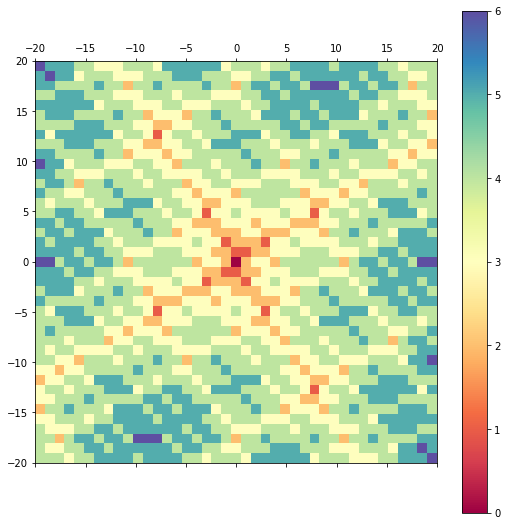

In [13]:
#def plot_approx_neighbor_order(n, nbig, m, x0, max_points, max_order):

plot_approx_neighbor_order(20, 3000, m=m, x0=[1,0], max_points=4000000, max_order=11)
plt.colorbar()
plt.show()

### How 2 hyperbolas can be non-intersecting

In [10]:
def plot_no_intersection(a, c, xmax=40):
    xs = []
    ys = []
    for x in np.linspace(-xmax, xmax+1,100):
        for y in np.linspace(-xmax, xmax+1, 100):
            if intersection(a, [x,y], c) is None:
                xs.append(x)
                ys.append(y)
    plt.plot(xs,ys,"r.")

### Points that can not be decomposed as sum of 2 order-1 neighbors

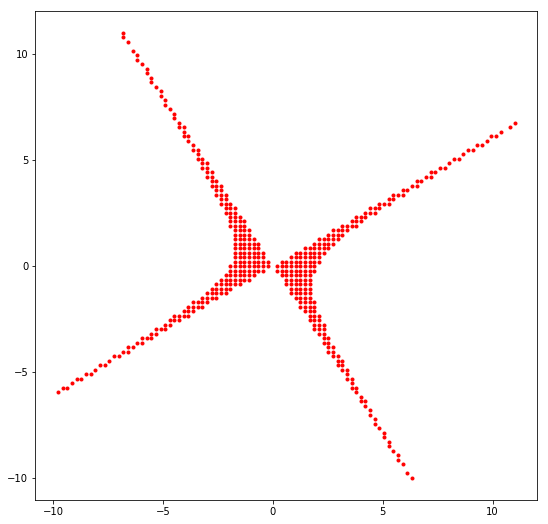

In [11]:
plot_no_intersection(a, c, 10)
plt.show()

## Intersection os non-equal hyperbolas
What is 2 hyperbolas have different constant term?

$$\begin{cases} x'Ax = c_1 \\
                (x-p)'A(x-p) = c_2
  \end{cases}$$
 
Expand 2nd

$$ x'Ax - 2p'Ax + p'Ap = c_2  $$
$$ 2p'Ax = c_2-c_1 + p'Ap $$
$$ p'Ax = \frac{\Delta c}2 + \frac12 p'Ap$$

Decompose $s$ as sum of 2 vectors: $p, q$, where $q \perp Ap$

$$x = w p + t q$$

and substitute:

$$w p'Ap = \frac{\Delta c}2 + \frac12 p'Ap$$

## Intersection os non-equal hyperbolas
What is 2 hyperbolas have different constant term?

$$\begin{cases} x'Ax = c_1 \\
                (x-p)'A(x-p) = c_2
  \end{cases}$$
 
Expand 2nd

$$ x'Ax - 2p'Ax + p'Ap = c_2  $$
$$ 2p'Ax = c_1-c_2 + p'Ap $$
$$ p'Ax = \frac{\Delta c}2 + \frac12 p'Ap$$

Decompose $s$ as sum of 2 vectors: $p, q$, where $q \perp Ap$, $q=ARp$

In this case, $q'Aq = \det(A)p'Ap$

$$x = w p + t q$$

and substitute:

$$w p'Ap = \frac{\Delta c}2 + \frac12 p'Ap$$
$$w = \frac{\Delta c + p'Ap}{2 p'Ap} = \frac12 + \frac{\Delta c}{2 p'Ap}  $$

and $t$ is any.


In [97]:
import sympy as sp
import sympy.abc as abc
sp.init_printing(use_latex="mathjax")
w, t = abc.w, abc.t
pap = sp.Symbol('pap')
c1, c2 = map(sp.Symbol, ('c1','c2'))
dc = c1-c2
w0 = sp.solve(w*pap -(dc/2 + pap/2), w)[0]
w0

c₁ - c₂ + pap
─────────────
    2⋅pap    

In [98]:
da = sp.Symbol("da")
sols_t = sp.solve(w0**2*pap + t**2*da*pap - c1, t)
sols_t

⎡     ____________________________________________________        ____________
⎢    ╱     2                          2                 2        ╱  ⎛  2      
⎢   ╱  - c₁  + 2⋅c₁⋅c₂ + 2⋅c₁⋅pap - c₂  + 2⋅c₂⋅pap - pap        ╱  -⎝c₁  - 2⋅c
⎢  ╱   ──────────────────────────────────────────────────   -  ╱   ───────────
⎢╲╱                            da                            ╲╱               
⎢─────────────────────────────────────────────────────────, ──────────────────
⎣                          2⋅pap                                              

__________________________________________ ⎤
                    2                 2⎞   ⎥
₁⋅c₂ - 2⋅c₁⋅pap + c₂  - 2⋅c₂⋅pap + pap ⎠   ⎥
─────────────────────────────────────────  ⎥
              da                           ⎥
───────────────────────────────────────────⎥
          2⋅pap                            ⎦

In [99]:
t0 = sols_t[0]
p, q = map(sp.Symbol, ('p', 'q'))
w0*p + t0*q


                           ___________________________________________________
                          ╱     2                          2                 2
                         ╱  - c₁  + 2⋅c₁⋅c₂ + 2⋅c₁⋅pap - c₂  + 2⋅c₂⋅pap - pap 
                    q⋅  ╱   ──────────────────────────────────────────────────
p⋅(c₁ - c₂ + pap)     ╲╱                            da                        
───────────────── + ──────────────────────────────────────────────────────────
      2⋅pap                                    2⋅pap                          

_
 
 
 
 
─
 

Ok, this is way more clean expresstion
$$\frac{
    p(c_1-c_2 + pap) + q\sqrt{
        \frac1{da}\left(-(c_1-c_2)^2+2(c_1+c_2)pap - pap^2\right)
    }
  }{
    2 pap
  }$$

$$\frac{
    p(c_1-c_2 + pap) + q\sqrt{
        -\frac1{da}\left((pap-c_1-c_2)^2-4c_1c_2\right)
    }
  }{
    2 pap
  }$$

In [112]:
#Determinant of A is:
np.linalg.det(a)

-5.0

Thus, it is negative, and should always be. Therefore, expression under the square root is positive for most values.

FOr large $p'Ap$, root, when it exists, is equal to $ceil \left|\frac{pap-c_1-c_2}{\sqrt{\det(A)}}\right|$

## Show cell neighbors

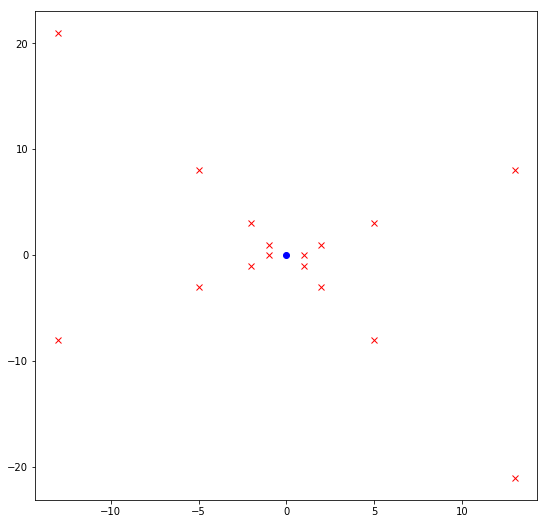

In [12]:
m = np.array([[2,1],[1,1]])
def plot_neighbors(n0,xmax=10):
    im = np.linalg.inv(m)
    xy = n0
    def powers(m):
        xy = n0
        points = []
        while np.max(np.abs(xy)) < xmax:
            xy = m.dot(xy)
            points.append(xy)
        return points
    points = np.stack(powers(im) + [n0] + powers(m))
    plt.plot(points[:,0], points[:,1], "rx")

plot_neighbors([1,0])
plot_neighbors([-1,0])
plt.plot([0],[0],'bo')
plt.show()
    

## Find cell with integer coordinates and minimal distance to the origin

In [13]:
def mindist(a):
    """find integer of the minimal pseudo-distance, minimizing
    x'ax
    """
    dmin = None
    pmin = []
    for x in range(-10,10):
        for y in range(-10,10):
            if not (x or y): continue
            p = np.array([x,y])
            d = int(abs(p.dot(a).dot(p)))
            dd = (d, abs(x)+abs(y)) #search for points that have simplest coordinates
            if (dmin is None) or (dd < dmin):
                dmin = dd
                pmin = [p]
            elif dd == dmin:
                pmin.append(p)
    return pmin, dmin[0]

a = tfm2qform([[2,1],[1,1]])
points, dmin = mindist(a)
print("A matrix is")
print(a)
print(f"Minimal pseudo-distance is {dmin}, achieved for points:")
for p in points:
    print(f"  {p}")

A matrix is
[[ 2 -1]
 [-1 -2]]
Minimal pseudo-distance is 2, achieved for points:
  [-1  0]
  [ 0 -1]
  [0 1]
  [1 0]


# Rewrite systems for minkovsky grids

Consider group with 2 generators:

* $r$ : hyperbolic rotation
* $t$ : grid translation by 1

Matrix representations:

In [42]:
r = np.array([[2,1,0],[1,1,0],[0,0,1]])
t = np.array([[1,0,1],[0,1,0],[0,0,1]])
R = np.linalg.inv(r).astype(np.int)
T = np.linalg.inv(t).astype(np.int)

def dots(*mts):
    m = mts[0]
    for mi in mts[1:]:
        m = m.dot(mi)
    return m

Then $rtRRtr = ttt$

This is analog of zig-zag way, which is shorter than the straight line.

In [49]:
#Checking this:
dots(r,t,R,R,t,r)

array([[1, 0, 3],
       [0, 1, 0],
       [0, 0, 1]])

In [24]:
r.dot([1,0,1])

array([2, 1, 1])

In [29]:
R.dot([1,0,1])

array([ 1, -1,  1])

Translation up, by (0,1) is given by $RTrt$:

In [47]:
dots(R,T,r,t)

array([[1, 0, 0],
       [0, 1, 1],
       [0, 0, 1]])

And generally, by (0,n) is $RT^nrt^n$:

In [48]:
dots(R,T,T,T,r,t,t,t)

array([[1, 0, 0],
       [0, 1, 3],
       [0, 0, 1]])

Neighborhood order for a cell is, then, the minimal number T and t steps in the path to the cell.
Is it possible to apply knuth-bendix algorhythm to make convergent rewrite system?

Starting rules:

* $rtRRtr = ttt$
* $rR = Rr = Tt = tT = e$

Experiments with my older knuth_bendix implementation in Python show no success though.

# Effective neighbor calculation algorhithm

The algorhyths is not tested, but I am almost sure in it.

Idea: **simplest paths**
Assume that a lattice, with elementary skew $R$ is defined, and additionally, an *elementary translation* $T$ is defined (translation from the cell to the nearest neighbor. Usually, $T$ is translation by 1 cell. Then any larger translation can be obtained as superposition of transformations $R,R^{-1},T,T^{-1}$, called *path*. Two paths are equivalent if they describe the same transformation. Of all equivalent paths, **simplest paths** are the paths with minimal total number of $T,T^{-1}$ steps.

For example, on the 2111 lattice, let $T$ is translation by $(1,0)$. Then paths $TTT$ and $RTR^{-2}TR$ are equivalent, of them the latter is simpler. It is one of the simplest paths for translation $(3,0)$ (another one is $R^{-1}TR^2R^{-1}$). 

Let's call the number of $T,T^{-1}$ steps in the simplest path **complexity** of the translation. Then neighbors are separated by translation of complexity 1. Order-2 neighbors have translation of complexity 2 etc.

Translation complexity behaves as true metric, triangle inequality holds for it.

## Calculating translation complexity

Any translation $X$ can be represented as superposition of powers of rotated elementary translations:

$$X = ... (R^{-2} T^{a_{-2}} R^2) (R^{-1} T^{a_{-1}} R) T^{a_0}(R T^{a_1} R^{-1})(R^2 T^{a_2} R^{-2})... $$

Where each power of $T$ present not more than once. Due to linear properties of translations, order can be arbitrary:

$$ (R^aT^nR^{-a})(R^bT^mR^{-b}) = (R^bT^mR^{-b})(R^aT^nR^{-a}) $$

Thus, any translation $X$ can be represented as a finite set of tuples $(n, a_n)$ for each nonzero $a_n$, or as a two-way infinite table of $a_n$ values with finite number of nonzero cells:

$n$ : | ... | -2 | -1 | 0 | 1 | 2 | ... 
----|-----
$a_n$ :| ...| ${a_{-2}}$ | ${a_{-1}}$ | ${a_0}$ | ${a_1}$ | ${a_2}$ | ...

There are many equivalent representations for each translation. For example, the above equality says that transoation $(a_0=3)$ is equivalent to translation $(a_1=1)(a_{-1}=1)$.

Complexity of translation is:
$$C = \sum_{i=-\infty}^{\infty}|a_i| $$

Equivalent translations are given by the characteristic equation of the $R$ matrix:

In [4]:
np.poly([[2,1],[1,1]])

array([ 1., -3.,  1.])

$$R^2-3R+R=0$$

This means that adding $(k,-3k,k)$, where $k$ is any integer number, to any 3 consequent cells in the $a_i$ table does not change translation. Fro example, let's ensure that $(a_0,3) = (a_1=1, a_{_1}=1)$:


$a_{-1}$ | $a_0$ | $a_1$
----|---
0 | 3 | 0
+1 | -3 | +1
*1* | *0* | *1*


## Simplest path calculation

[QUestion on math overflow](https://math.stackexchange.com/questions/2537017/how-to-find-the-simplest-form-of-integer-matrix-polynomial)

THe most important idea: <s>**simple greedy algorhythm is enough to minimize complexity** . In other words: add $(k, -3k, k)$ triples to the table cells until it reduces $\sum|a_i|$. This is true, because $C=\sum |a_i|$ is a *convex function* of coefficients $k$.</s>

Experiment shows that this **idea fails**. There are local minima, where the process can stuck. For example, for polynomial $(1,-3,1)$, path $(2,1,1,2)$ is irreducible, but can be reduced to $(1,0,0,0,0,1)$.

This gives an effective way to calculate translation complexity and find common neighbors for 2 cells: if translation complexity is 2, then they have 2 common neighbors for each of the non-zero $a_i$.


In [18]:
def charpoly2(m):
    #integer version of the 2x2 characteristic polynomial. starts from lower powers
    (a,b),(c,d) = m
    return [a*d-b*c, -a-d, 1]

assert charpoly2([[2,1],[1,1]]) == [1,-3,1]

def simplify_greedy(path, charpoly):
    """path: dict[int->int]. maps n to nonzero a_n. zeros are not in the map.
    """
    path = path.copy()
    def offsets(path):
        visited = set()
        for i in path.keys():
            for di in range(-len(charpoly), 0):
                i1 = i + di
                if i1 not in visited:
                    visited.add(i1)
                    yield i1
        
    def sumabs(s): return sum(abs(xi) for xi in s)
    
    def minblock(blk):
        ratios = [divmod(bi,pi) for bi, pi in zip(blk, charpoly) if pi!=0]
        def corners():
            for (r, rem) in ratios:
                if rem == 0:
                    yield r
                else:
                    yield r
                    yield r+1
                    
        variants = [ [bi-rr*pi for bi, pi in zip(blk, charpoly)]
                     for rr in set(corners())
                   ]
        return min(variants, key = sumabs)
         
    need_continue = True
    while need_continue:
        need_continue = False
        for i0 in offsets(path):
            block = [path.get(i0+i, 0) for i in range(len(charpoly))]
            block1 = minblock(block)
            if block1 == block:
                #no minimization
                continue
            need_continue = True
            #write block back
            for i, new_bi in enumerate(block1):
                if new_bi == 0:
                    if (i0 + i) in path:
                        del path[i0+i]
                else:
                    path[i0+i] = new_bi
            break
    return path 


In [19]:
simplify_greedy({0:3}, [1,-3,1])

{-1: 1, 1: 1}

In [96]:
simplify_greedy({0:3000}, [1,-3,1])

{-8: 1,
 -6: 2,
 -4: 2,
 -3: 2,
 -2: 2,
 -1: 1,
 0: 2,
 1: 1,
 2: 2,
 3: 2,
 4: 2,
 6: 2,
 8: 1}

In [20]:
def path2xy(path, m, t0=np.array([1,0], dtype=np.int64)):
    xy = np.array([0,0], dtype=np.int64)
    for power, translation in path.items():
        mp = np.linalg.matrix_power(m,power).astype(np.int64).dot(t0)
        xy += mp * int(translation)
    return xy
def xy2path(xy, m, t0=np.array([1,0], dtype=np.int64)):
    mt0 = m.dot(t0)
    tt=np.stack((t0, mt0)).T
    itt = np.linalg.inv(tt)
    #check that it is integer
    if not (np.abs(itt - np.round(itt)) < 1e-5 ).all():
        print(itt)
        raise ValueError("Inverse transform is not integer, what to do?")
    itt = itt.astype(np.int64)
    k0, k1 = itt.dot(xy)
    p = {}
    if k0 != 0: p[0]=k0
    if k1 != 0: p[1]=k1
    return p

In [22]:
M = np.array([[2,1],[1,1]], dtype=np.int64)

xy0 = np.linalg.matrix_power(M,3).dot([1,0]) + np.linalg.matrix_power(M,-2).dot([1,0])
xy0 = xy0.astype(np.int64)
print("XY original", xy0)

p = xy2path(xy0, M)
mp = simplify_greedy(p, charpoly2(M))
p0 = {3:1, -2:1}
print("Path:",p, "simple",mp)
xy1 = path2xy(p, M)
xy2 = path2xy(mp, M)
xy01 = path2xy(p0, M)
print("XY:",xy1, "simplified:",xy2, "p0:", xy01)

XY original [15  5]
Path: {0: 5, 1: 5} simple {0: 1, -1: 2, 2: 2, 1: 1}
XY: [15  5] simplified: [15  5] p0: [15  5]


#### Greedy algorithm fails
Simplest example: (5,5|).  simplifies to (2,1,1|,2), but simplest is (1,0,0,0|,0,1)

### Plot how value depends on k

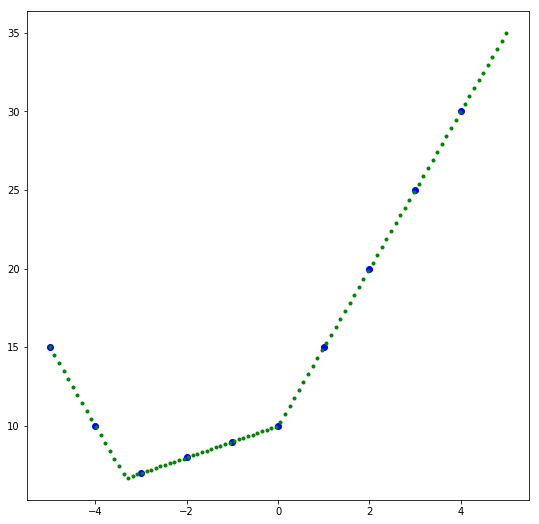

In [35]:
fun = np.vectorize(lambda x: sum(abs(bi-pi*x) for bi, pi in zip([0,10,0],[1,-3,1])))
plt.plot(range(-5,5), fun(range(-5,5)), "bo", np.linspace(-5,5,100), fun(np.linspace(-5,5,100)), 'g.')
plt.show()

### String rewrite approach (failed)

Using greedy rewriter, it is alwayspossible to reduce string representation of the path to a string ov values in the range \[-2..2\] (higher values can always be reduced). This is true for other reducers, with n higher than 3.

What could be done further? Let's make a rewrite table

In [98]:
def make_final_rewrite_table(n):
    p = (1, -n, 1)
    def weight(s): return sum(map(abs, s))
    def add_p(s, k):
        return tuple( si+k*pi for si,pi in zip(s, p) )
    def rewrite(s):
        return min((add_p(s,k) for k in range(-n,n+1)),
                  key = weight)
    table = {}
    for a in range(-n+1,n):
        for b in range(-n+1,n):
            for c in range(-n+1,n):
                s = (a,b,c)
                rs = rewrite(s)
                if rs!=s : 
                    table[s] = rs
    return table

In [99]:
make_final_rewrite_table(3)

{(-2, -2, 1): (-3, 1, 0),
 (-2, -2, 2): (-3, 1, 1),
 (-2, 1, -2): (-1, -2, -1),
 (-2, 1, -1): (-1, -2, 0),
 (-2, 2, -2): (-1, -1, -1),
 (-2, 2, -1): (-1, -1, 0),
 (-2, 2, 0): (-1, -1, 1),
 (-2, 2, 1): (-1, -1, 2),
 (-2, 2, 2): (-1, -1, 3),
 (-1, -2, 1): (-2, 1, 0),
 (-1, -2, 2): (-2, 1, 1),
 (-1, 1, -2): (0, -2, -1),
 (-1, 1, -1): (0, -2, 0),
 (-1, 2, -2): (0, -1, -1),
 (-1, 2, -1): (0, -1, 0),
 (-1, 2, 0): (0, -1, 1),
 (-1, 2, 1): (0, -1, 2),
 (-1, 2, 2): (0, -1, 3),
 (0, -2, 1): (-1, 1, 0),
 (0, -2, 2): (-1, 1, 1),
 (0, 2, -2): (1, -1, -1),
 (0, 2, -1): (1, -1, 0),
 (1, -2, -2): (0, 1, -3),
 (1, -2, -1): (0, 1, -2),
 (1, -2, 0): (0, 1, -1),
 (1, -2, 1): (0, 1, 0),
 (1, -2, 2): (0, 1, 1),
 (1, -1, 1): (0, 2, 0),
 (1, -1, 2): (0, 2, 1),
 (1, 2, -2): (2, -1, -1),
 (1, 2, -1): (2, -1, 0),
 (2, -2, -2): (1, 1, -3),
 (2, -2, -1): (1, 1, -2),
 (2, -2, 0): (1, 1, -1),
 (2, -2, 1): (1, 1, 0),
 (2, -2, 2): (1, 1, 1),
 (2, -1, 1): (1, 2, 0),
 (2, -1, 2): (1, 2, 1),
 (2, 2, -2): (3, -1, -1),
 (2

Does not work... It produces 3s and any attempt to avoid them give infinite ruleset.

### Another idea: "pull and split"

ANy value is represented as a pair of neighbor terms initially. Using the fact that (1,-3,1) pattern has 1s in the ends, it is possible to pull this nonzero pair to the left or to the right indefinitely:

```
0 0    0  5 5 0 0 0 0
0 0   -5 20 0 0 0 0 0   #-5*(1 -3 1)
0 -20 55  0 0 0 0 0 0
```
If initial pair is $(a,b)$, then pulled left it becomes $(-b, a+3b)$, and to the right: $(a+3b, -b)$. Thus, pulling is equivalent to multiplication by $\left(\begin{matrix}0&-1\\1&3\end{matrix}\right)$

Eigenvalues of this matrix are the same as of M, since determinant is 1 and trace is 3.


In [14]:
#Example:
Left = np.array([[0,-1],[1,3]])
Left.dot(Left.dot([5,5]))

array([-20,  55])

Using pull, it should be possible to find the local minimum of complexity.
However, how to split the value?

Let's try it.

```
0 0  0  0  5 5 0 0 0 0
0 0 -5 15  0 5 0 0 0 0
```
Now we have 2 groups: -5,15 and 0,5. Hm, nothing good.
```
0 0  0  0  5  5 0 0 0 0
0 0  0  2  -1 7 0 0 0 0
0 0  0  2  1  1 2 0 0 0
```
here, (21) and (12) groups.

In [11]:
Left.dot(Left.dot([2,1]))

array([-5, 14])

Impossible to pull them... and what if added 1 -2 -2 1 to the center?
```
0 0  0  0  5  5 0 0 0 0
0 0  0  2  1  1 2 0 0 0
0 0  0  3 -1 -1 3 0 0 0
```

In [16]:
Left.dot([3,-1])

array([1, 0])

### Hmm, another idea: get rid of 2s
Apply (1,-3,1) addition until there are no 2s. Should be possible?
this would generate suboptimal rewrite for (2): (1,-1,1). However, such cases can be restored by post-processing.



In [63]:
def simplify_no2(path, charpoly):
    """path: dict[int->int]. maps n to nonzero a_n. zeros are not in the map.
    """
    path = path.copy()
            
    def minblock(blk):
        r, rem = divmod(blk[1], charpoly[1]) #by 3
        if rem == 0:
            corners = (r,)
        else:
            corners = (r, r+1)
                    
        variants = [ [bi-rr*pi for bi, pi in zip(blk, charpoly)]
                     for rr in corners
                   ]
        return min(variants, key = lambda abc: abs(abc[1]))
         
    need_continue = True
    while need_continue:
        need_continue = False
        for i0_, val in path.items():
            if abs(abs(val)-abs(charpoly[1])) >= abs(val):
                continue
            i0 = i0_ - 1
            
            block = [path.get(i0+i, 0) for i in range(len(charpoly))]
            block1 = minblock(block)
            #print(f"orig block {block}, rewrite to {block1}")
            if block1 == block:
                #no minimization
                continue
            need_continue = True
            #write block back
            for i, new_bi in enumerate(block1):
                if new_bi == 0:
                    if (i0 + i) in path:
                        del path[i0+i]
                else:
                    path[i0+i] = new_bi
            break
    return path 

Let's try it...

In [70]:
M = np.array([[2,1],[1,1]], dtype=np.int64)

xy0 = np.linalg.matrix_power(M,3).dot([1,0]) - np.linalg.matrix_power(M,-10).dot([1,0]) + np.linalg.matrix_power(M,-2).dot([1,0])
xy0 = xy0.astype(np.int64)
print("XY original", xy0)

p = xy2path(xy0, M)
mp = simplify_no2(p, charpoly2(M))
print("Path:",p, "simple",mp)
xy1 = path2xy(p, M)
xy2 = path2xy(mp, M)
print("XY:",xy1, "simplified:",xy2)

XY original [-4166  6770]
Path: {0: -17706, 1: 6770} simple {4: 1, 2: -1, 1: -1, 3: -1, -1: -1, 0: -1, -10: -1, -3: 1, -2: -1}
XY: [-4166  6770] simplified: [-4166  6770]


Hmmm, it seems to be **working**!

In [71]:
p = simplify_no2(xy2path([1000,0], M), charpoly2(M))
print(p)
pp = simplify_greedy(p, charpoly2(M))
print(pp)

{-3: -1, 3: -1, -7: 1, -5: 1, 5: 1, 7: 1, -1: -1, 1: -1, -4: 1, 4: 1, -2: 1, 0: 1, 2: 1}
{-3: 2, 3: -1, -7: 1, -5: 1, 5: 1, 7: 1, -1: -1, 1: 2, 4: 1}


In [68]:
def simplify(p, cp):
    return simplify_greedy(simplify_no2(p, cp),cp)

No, **still failing**:

In [69]:
p = xy2path([-4166,6770], M)
print(p)
simplify(p, charpoly2(M))

{0: -17706, 1: 6770}


{-10: -1, -3: 1, -2: -1, -1: -1, 0: -1, 1: -1, 2: -1, 3: -1, 4: 1}

# Newton method approach

Consider equations system

$m=((-2,1),(1,2))$

$$\begin{cases} -x^2+xy+y^2=1 \\ -(x-x_0)^2+(x-x_0)(y-y_0)+(y-y_0)^2=1 \end{cases} $$

maxima code 
```
pd(x,y) := (-x^2+y^2+xy-1);

e1 : pd(x,y);
e2 : pd(x0-x, y0-y);

J : matrix( [diff(e1,x), diff(e1,y)], [diff(e2,x), diff(e2,y)] );

dj : determinant(J);

IJ : ratsimp(invert(J) * dj);

dv : ratsimp(- IJ . matrix([e1],[e2]) / dj);```

Resutls are not very easy to use...